# Analysis of 10x Visium Prostate Adenocarcinoma dataset

In this section, we analyze the 10x Visium Prostate Adenocarcinoma data. The original dataset can be downloaded from 10x Visium dataset repository (https://www.10xgenomics.com/datasets/human-prostate-cancer-adenocarcinoma-with-invasive-carcinoma-ffpe-1-standard-1-3-0).

In [1]:
import os
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import scanpy as sc

from STForte import STGraph
from STForte import STForteModel
import STForte.helper as stfhelper
from STForte.helper import save_gdata, load_gdata

from pathlib import Path
trial_name = "trial-Prostate_Adenocarcinoma_10x_Visium"
trial_dir = Path().resolve() / trial_name
data_dir = Path().resolve() / ".." / "data" / "Visium_FFPE_Human_Prostate_Cancer"
if not os.path.exists(trial_dir):
    os.makedirs(trial_dir)

Global seed set to 0


## Data preparation

We preprocess the original 10x output files. The spatial graph is constructed based on distance neighbors. We used PCA to preprocess the gene experssion profiles. We employ a padding strategy to enable analysis at a fine-grained resolution, imputing the patterns for unobserved locations.

In [2]:
adata = sc.read_visium(data_dir)
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 4371 × 17943
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [3]:
d = adata.uns['spatial']["Visium_FFPE_Human_Prostate_Cancer"]['scalefactors']['fiducial_diameter_fullres']
stgraph = STGraph.graphFromAnndata(
    adata=adata,
    d=d,
    )
stgraph.pca()
stgraph.padding(reconstruct_knn=True, reconstruct_k=18)
gdata = stgraph.topyg()
gdata

d-based initialize:   0%|          | 0/4371 [00:00<?, ?it/s]

PCA pre-compression for data, from 16907 onto 300-dim.
Scaling data: None; SVD solver: full; random_state=42.
Start compression...	Done! Elapsed time: 38.21s.


brute-force knn initialize:   0%|          | 0/17040 [00:00<?, ?it/s]

Data(x=[17040, 300], xfp=[17040, 300], adj_t=[17040, 17040, nnz=306720], inv_dist=[306720], value_idx=[4371], infer_idx=[12669], coord=[17040, 2], x_id=[17040], mask_idx=[0])

## Constructing and fitting the STForte Model

We establish the model and fit it to obtain the latent encodings. The `lmbd_cross` is set to $1$ (default is $10$) to ensure more heterogeneity for spatial region identification under complex tumor micro-environment.

In [4]:
model = STForteModel(adata=adata, gdata=gdata,
                     output_dir=trial_dir / "pl_ckpts",
                     module_kwargs=dict(lmbd_cross=1.))
model.fit()

Global seed set to 42


/home/poncey/miniconda3/envs/stforte_env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:474: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type              | Params
----------------------------------------------------
0 | attr_encoder  | Sequential        | 71.9 K
1 | strc_encoder  | Sequential_53b22a | 71.9 K
2 | attr_decoder  | Sequential        | 72.2 K
3 | strc_decoder  | Sequential        | 2.1 K 
4 | discriminator | Sequential        | 1.1 K 
----------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.877  

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=450` reached.


Save the AnnData object, graph data, and model parameters for reproduction. Then, save the STForte output results. Model or data can be loaded for other analysis pipelines.

In [5]:
if not os.path.exists(trial_dir / "data"):
    os.makedirs(trial_dir / "data")
save_gdata(gdata, path=trial_dir / "data/gdata.pkl")
adata.write_h5ad(trial_dir / "data/trial.h5ad")
model.save_state_dict(trial_dir / "models", alias="STForteModel_prostate_cancer_10x")
# For analysis in original resolution
model.get_latent_original(adata)
if not os.path.exists(trial_dir / "outputs"):
    os.makedirs(trial_dir / "outputs")
adata.write(trial_dir / "outputs/stforte.h5ad")
# For analysis in padding resolution
adata_sp = model.get_result_anndata()
adata_sp.write_h5ad(trial_dir / "outputs/sp.h5ad")

## Spatial region identification and Visiualize STForte encodings

ATTR encoding from STForte is used for spatial region identification considering the heterogenity of tumor micro-environment. The clustering results are obtained by varying the resolution from 0.1 to 1 with a step size of 0.05. The best results is selected based on the highest silhouette coefficient.

In [6]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
sc.set_figure_params(dpi=80 , fontsize=18)
plt.rcParams['font.sans-serif'] = [
    'Arial',
    'Helvetica',
    'sans-serif',]

In [7]:
from sklearn.metrics import calinski_harabasz_score, silhouette_score

sc.pp.neighbors(adata, use_rep='STForte_ATTR')
elbow_res = np.arange(0.1, 1.0 + 0.05, 0.05)
ch_elbow = []
ss_elbow = []
for res in elbow_res:
    labels = sc.tl.leiden(adata, resolution=res, copy=True).obs["leiden"]
    ss_elbow.append(silhouette_score(adata.obsm['STForte_ATTR'], labels))
    ch_elbow.append(calinski_harabasz_score(adata.obsm['STForte_ATTR'], labels))
ss_elbow = np.asarray(ss_elbow)
ch_elbow = np.asarray(ch_elbow)

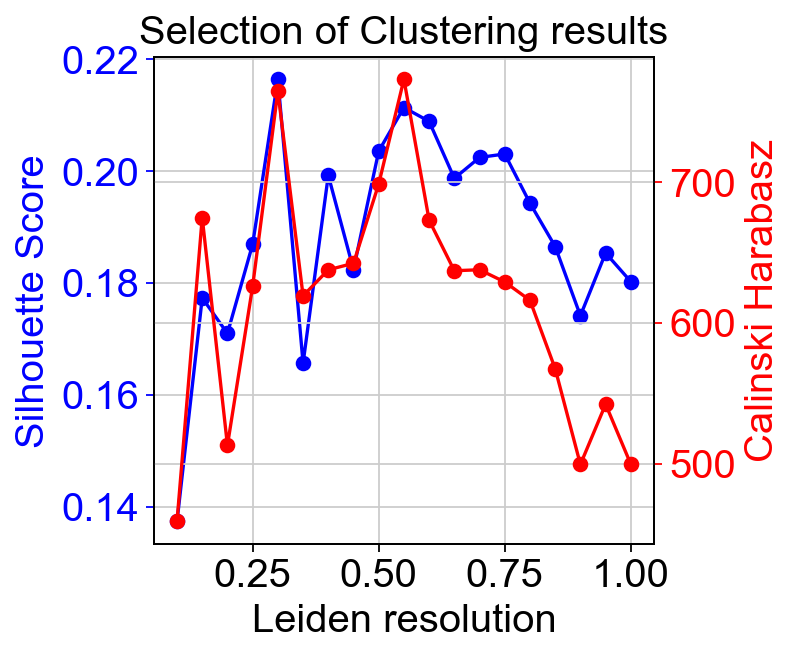

In [8]:
fig, ax1 = plt.subplots()

ax1.plot(elbow_res, ss_elbow, 'bo-', label='sin(x)')
ax1.set_xlabel('Leiden resolution')
ax1.set_ylabel('Silhouette Score', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(elbow_res, ch_elbow, 'ro-', label='cos(x)')
ax2.set_ylabel('Calinski Harabasz', color='r')
ax2.tick_params('y', colors='r')

plt.title('Selection of Clustering results')
plt.show()

Then, we visualize the clustering results at the resolution with the best silhouette coefficient.

In [9]:
max_sc = max(ss_elbow)
res_max_sc = elbow_res[np.argmax(ss_elbow)]
print(f"The highest Silhouette Score is {max_sc:.2f} under resolution of {res_max_sc:.2f}")

The highest Silhouette Score is 0.22 under resolution of 0.30


In [10]:
sc.pp.neighbors(adata, use_rep='STForte_ATTR')
sc.tl.leiden(adata, resolution=res_max_sc)
adata.obs['leiden'] = adata.obs['leiden'].cat.rename_categories(dict(((i, f'C{int(i) + 1}') for i in adata.obs['leiden'].cat.categories)))
sc.tl.umap(adata)

<Axes: title={'center': 'UMAP'}, xlabel='UMAP1', ylabel='UMAP2'>

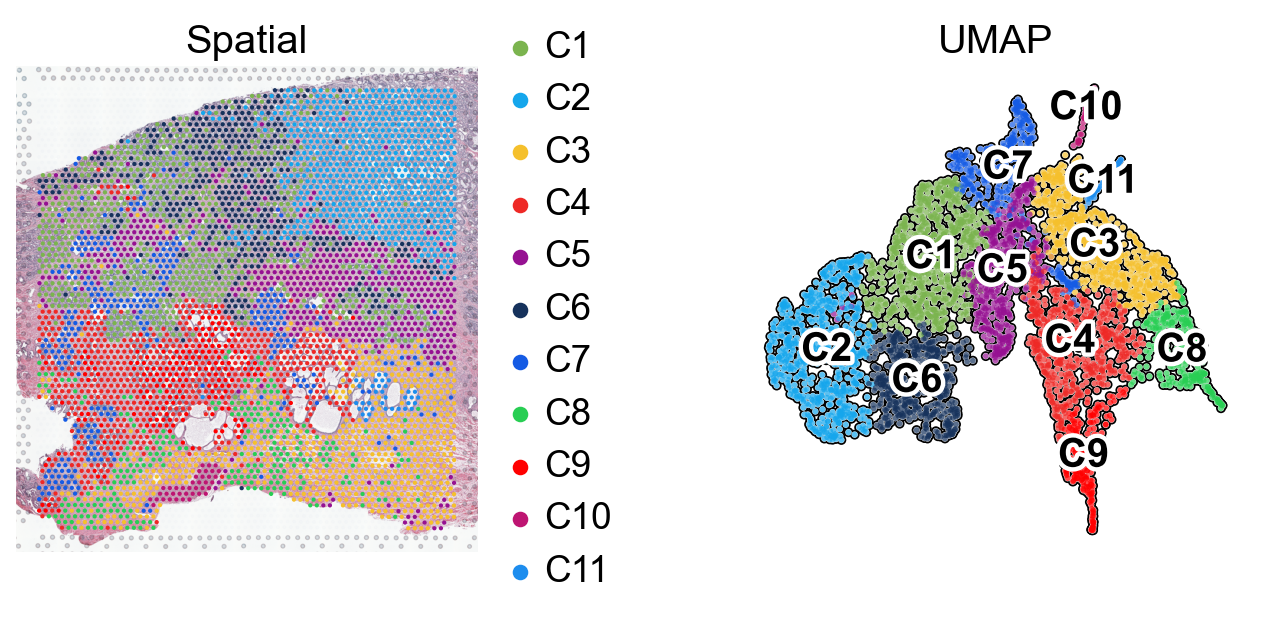

In [11]:
palette = stfhelper.pl.prism_1960s_palette + stfhelper.pl.prism_2000s_palette

# sc.pl.spatial(adata, color=['leiden'], palette=palette)
ncols, nrows = 2, 1
figsize, wspace = 4, 0.5
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize),
)
plt.subplots_adjust(wspace=wspace)
sc.pl.spatial(
    adata,
    color=["leiden"],
    title=["Spatial"],
    ax=axs[0],
    palette=palette,
    frameon=False,
    show=False,
)
sc.pl.umap(
    adata,
    color=["leiden"],
    title=["UMAP"],
    ax=axs[1],
    frameon=False,
    legend_loc="on data",
    legend_fontoutline=4,
    add_outline=True,
    show=False,
)